# 1. [人工智能] 人脸检测从传统到深度学习的方法—[原文链接](http://blog.seanzou.com/archives/-ren-gong-zhi-neng-ren-lian-jian-ce-cong-chuan-tong-dao-shen-du-xue-xi-de-fang-fa)
## 1.1 简介
![image.png](http://blog.seanzou.com/upload/2022/04/image-f0e18a1811694ceb8a167bcb95be4985.png)
以下大部分都基于[人脸检测从传统到深度学习的方法](https://kevinnan.org.cn/index.php/archives/683/)：
从问题的领域来看，人脸检测当前属于目标检测领域，主要分为多目标+背景和特定目标+背景：
1. 多分类问题：图像中有多个分类目标。**n（目标）+1（背景） = n+1分类**
2. 特定类别目标检测：人脸检测、行人检测、车辆检测。**1（目标）+1(背景)= 2分类**

从发展历史来看，人脸检测主要分为非深度学习（传统）和深度学习阶段（现代）：
1. 非深度学习阶段：主要基于rigid-templates的方法（Haar+AdaBoost分类、LBP+AdaBoost、HOG+SVM）以及基于可变组件模型（Deformable Part Model, DPM）的方法，DPM是深度学习之前最有效的人脸检测算法。
2. 深度学习阶段：R-CNN、SSD。

## 1.2 导入所需的包

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# io, os, http, plot, regex helper
from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from PIL import Image # load image
import io # Input/Output Module
import os # OS interfaces
import re # regular expression

# data manager( e.g., data frame, numpy) helper
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# computer vision: https://opencv.org
import cv2 # OpenCV package

# pre processor
from mtcnn.mtcnn import MTCNN

# dlib
import dlib

# tensorflow - Keras: https://keras.io
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPooling2D # keras NN layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data augmentation
from tensorflow.keras import Model, Input, Sequential # keras NN related
import tensorflow as tf # tensorflow package

# assign GPU
physical_gpus = tf.config.list_physical_devices('GPU') # get current GPU
tf.config.experimental.set_memory_growth(physical_gpus[0], True) # set GPU running method
print('Num GPUs Available', len(physical_gpus)) # see number of available GPU
print(physical_gpus) # print current available GPU

Num GPUs Available 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.3 Helper

In [15]:
# 下载model
def download_model(url, path):
    with request.urlopen(url) as r, open(path, 'wb') as f:
        f.write(r.read())

## 1.4 导入图片
图片来自：[日本这所被戏称”看颜值录取”的大学，选出的校花校草得长啥样？](http://www.hereinuk.com/516310.html)

(852, 1280, 3)


Text(0.5, 1.0, 'Image used for learning')

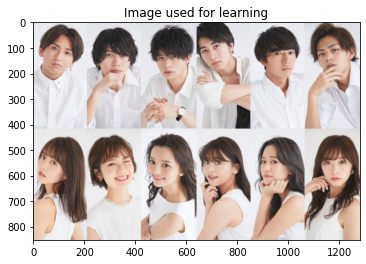

In [29]:
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for learning')

# 2. 传统阶段

## 2.1 Haar Cascade Classifier （级联分类器）
**Viola-Jones**对象检测框架，是2004年计算机视觉研究者**Paul Viola** 和 **Michael Jones**在论文[Rapid Object Detection using a Boosted Cascade of Simple Features](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf)中提出。他们开发了一个可以实时检测各种物体的框架，但主要的动机为人脸检测，论文中也以人脸检测作为例子展开。
一般来讲，Haar特征级联分类器主要由四部分构成：
1. 选择Haar-Like特征
2. 创建积分图Integral image
3. 训练AdaBoost
4. 创建级联分类器

优点：
1. 在CPU上可以实时运行
2. 简单的结构
3. 可以检测不同尺度的人脸

缺点：
1. 只能检测**正面人脸，侧脸难以检测**
2. 会有很多错误的检测
3. 有遮挡的场景检测效果很差

In [22]:
# 下载模型
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
      "haarcascades/haarcascade_frontalface_default.xml"
download_model(url=url, path='xml/haarcascade_frontalface_default.xml')

# 导入模型
haar_face_cascade=cv2.CascadeClassifier('xml/haarcascade_frontalface_default.xml')

(852, 1280, 3)
faces number: 6


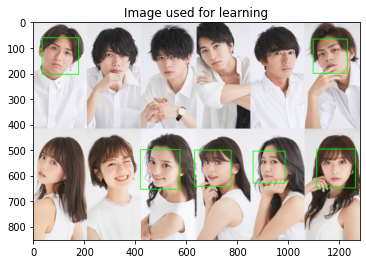

In [31]:
# 导入图片
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for learning')

# 检测人脸
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = haar_face_cascade.detectMultiScale(gray, scaleFactor=1.2, minSize=(10,10), maxSize=(200,200))
print("faces number:", len(faces))
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(img)

# 输出图片
img = Image.fromarray(img)
img.save("pics/learning_haarcascade_frontalface_default.jpg")

## 2.2 LBP Cascade Classifier
LBP (Local Binary Patterns)是纹理描述子，人脸由微纹理图案组成。提取LBP特征，形成特征向量，对人脸和非人脸进行分类。
LBP级联分类器的主要由以下四部分组成：
1. LBP Labelling， 图像二值化
2. Feature Vector， 图像被划为子区域每个子区域构造一个标签直方图。然后将子区域直方图拼接成一个大直方图，形成一个特征向量
3. AdaBoost Learning，利用AdaBoost构造强分类器，取出特征向量中无用的部分
4. Cascade Classifier，由上面获得的AdaBoost组成级联分类器。从简单的分类器到强分类器对图像子区域进行评价。**如果在该阶段任何一个分类器分类失败，则在该迭代处丢弃。只有面部区域可以通过所有的分类阶段。**

优点：
1. 计算简单、快速
2. 比Haar更短的训练时间
3. 对局部照明改变更robust
4. 对遮挡场景更robust

缺点：
1. 相比Haar准确率更低
2. 有比较高的错误检测率

In [35]:
# 下载模型
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
      "lbpcascades/lbpcascade_frontalface.xml"
download_model(url=url, path='xml/lbpcascade_frontalface.xml')

# 导入模型
lbp_face_cascade=cv2.CascadeClassifier('xml/lbpcascade_frontalface.xml')

(852, 1280, 3)
faces number: 2


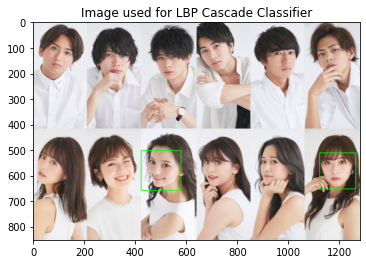

In [43]:
# 导入图片
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for LBP Cascade Classifier')

# 检测人脸
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = lbp_face_cascade.detectMultiScale(gray, scaleFactor=1.2, minSize=(10,10),maxSize=(300,300))
print("faces number:", len(faces))
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(img)

# 输出图片
img = Image.fromarray(img)
img.save("pics/learning_lbpcascade_frontalface.jpg")    

## 2.3 HOG and SVM
方向梯度直方图（Histogram of Oriented Gradient, HOG），是一种全局图像特征描述子（与LBP不同）。它通过计算和统计图像局部区域的直方图来构造特征。基于HOG特征和SVM分类器的人脸检测模型被广泛地使用。

优点：
1. 可以很好的检测正脸人脸，和轻度的侧脸
2. 在轻度的遮挡场景下也可以使用

缺点：
1. 主要的缺点是它不检测小的脸。因为它的训练集中最小的脸是80x80（dlib）。不过，你可以在自己的训练数据上训练HOG人脸检测模型来检测更小的人脸
2. 边框往往排除部分额头、甚至有时候会缺少下巴
3. 在严重遮挡场景下不能工作
4. 不能检测过度侧脸、和极端非正脸（向上或向下看）

(852, 1280, 3)
faces number: 11


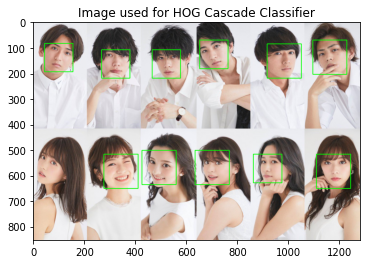

In [44]:
# 导入图片
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for HOG Cascade Classifier')

# 导入模型
detector = dlib.get_frontal_face_detector()

# 检测人脸
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = detector(gray, 2) # result
#to draw faces on image
print("faces number:", len(faces))
for result in faces:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    cv2.rectangle(img, (x, y), (x1, y1), (0, 255, 0), 2)
plt.imshow(img)

# 输出图片
img = Image.fromarray(img)
img.save("pics/learning_HOG.jpg")  

# 3. 深度学习阶段
## 3.1 MMOD
这个方法采用了基于CNN的最大边缘目标检测器（Maximum-Margin Object Detector, MMOD），来自[Max-Margin Object Detection](https://arxiv.org/pdf/1502.00046.pdf)。这个model是dlib社区的开发者写的，model可以从[Github-davisking/dlib-models/mmod_human_face_detector.dat.bz2](https://github.com/davisking/dlib-models/blob/master/mmod_human_face_detector.dat.bz2)下载。它使用了一个作者手工标记的数据集，来自ImageNet、PASCAL VOC、VGG、WIDER等不同数据集的图像组成，它包含了7220个图像，数据集的下载地址：[dlib_face_detection_dataset](http://dlib.net/files/data/dlib_face_detection_dataset-2016-09-30.tar.gz)。

优点：
1. 适用于不同的面部朝向
2. 扛遮挡能力强
3. 在GPU上运算很快

缺点：
1. 在CPU上运行相当慢（Python Dlib似乎都不支持在<font color='red'><b>GPU??</b></font>上运行）
2. 和HOG一样，不能检测小于80x80的人脸，但是一样的是，你可以在自己的训练数据上训练HOG人脸检测模型来检测更小的人脸
3. 边界框甚至比HOG检测器还要小

(852, 1280, 3)
faces number: 12


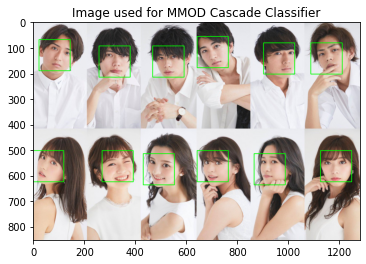

In [48]:
# 导入图片
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for MMOD Classifier')

# 导入模型，从https://github.com/davisking/dlib-models/blob/master/mmod_human_face_detector.dat.bz2下载
dnnFaceDetector=dlib.cnn_face_detection_model_v1("dat/mmod_human_face_detector.dat")
faceRects = dnnFaceDetector(img, 2)

# 检测人脸
print("faces number:", len(faceRects))
for faceRect in faceRects:
    x1 = faceRect.rect.left()
    y1 = faceRect.rect.top()
    x2 = faceRect.rect.right()
    y2 = faceRect.rect.bottom()
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)

# 输出图片
img = Image.fromarray(img)
img.save("pics/learning_MMOD.jpg")      

## 3.2 DNN Face (opencv)
在OpenCV3.3版本之后，据博主所说，contrib包含了dnn模块。自然也有了基于DNN的人脸检测模块。基于SSD（Single-Shot-Multibox Detector，来自于[SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf)）并且使用ResNet-10结构作为网络主干。[deploy.prototxt](https://es.technikum-wien.at/embedded_systems_public/Java-Exercises-9-JavaCV/-/blob/e76d2e48790ef87eaf403695312cd29a09ec0b30/data/deploy.prototxt)和[res10_300x300_ssd_iter_140000.caffemodel](https://es.technikum-wien.at/embedded_systems_public/Java-Exercises-9-JavaCV/-/blob/e76d2e48790ef87eaf403695312cd29a09ec0b30/data/res10_300x300_ssd_iter_140000.caffemodel)文件分别在[Gitlab-Java-Exercises9-JavaCV/data](https://es.technikum-wien.at/embedded_systems_public/Java-Exercises-9-JavaCV/-/tree/e76d2e48790ef87eaf403695312cd29a09ec0b30/data)找到。

优点：
1. 比上述四种方法准确率都高
2. 在CPU上也能够实时运行（视CPU性能而定）
3. 适用于不同的面部方向（上、下、左、右、侧）
4. 适用于严重遮挡场景
5. 可以检测不同尺度的人脸

缺点：
1. 不支持<font color='red'><b>GPU??为什么作为DL却不支持GPU??</b></font>

(852, 1280, 3)
[INFO] computing object detections...
face numbers: 12


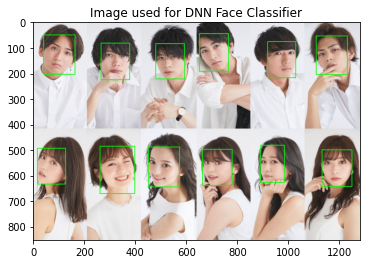

In [52]:
# 导入图片
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for DNN Face Classifier')

# 导入模型
prototxt_path = "dat/deploy.prototxt"
weight_path = "dat/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNetFromCaffe(prototxt_path, weight_path)

# 检测人脸
(h, w) = img.shape[:2]

blob = cv2.dnn.blobFromImage(img, 1.0, img.shape[:2], [104, 117, 123], False, False)
# Actually, if the size of the output image is set as (300,300), the result could not be good.
# blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
print("[INFO] computing object detections...")

net.setInput(blob)
detections = net.forward()
set_confidence = 0.5

face_num = detections[:,:,:,2].reshape(detections.shape[2])
print("face numbers:", face_num[face_num>set_confidence].shape[0])
# loop over the detections
for i in range(0, detections.shape[2]):
    # prediction
    confidence = detections[0, 0, i, 2]
    if confidence > set_confidence:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.imshow(img)

# 输出图片
img = Image.fromarray(img)
img.save("pics/learning_DNN.jpg")    

## 3.3 MTCNN
MTCNN又称（Multi-Task Cascaded Convolutional Networks），于2016年，由[Kaipen Zang](https://kpzhang93.github.io/)等人提出的[使用多任务级联卷积网络的联合人脸检测和对齐](https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf)（Joint Face Detection and Alignment using Multi-Task Cascaded Convolutional Networks, MTCNN）一度成为人脸检测最受欢迎的方法之一。MTCNN之所以受欢迎，是因为它在一系列基准数据集上获得了当时最先进的结果，而且除此之外，它还能够识别眼睛、嘴巴、鼻子等其他面部特征。
网络采用三级级联结构，首先将图片重新缩放到不同大小范围（图像金字塔），然后
1. 第一个模型P-Net提出候选面部区域
2. 第二个模型R-Net过滤边界框
3. 第三个模型O-Net提取面部其他特征


![image.png](http://blog.seanzou.com/upload/2022/04/image-ea420716755944b79880ce74b8b56fef.png)
MTCNN主要包含三个阶段
1. 通过浅层CNN快速生成候选窗口
2. 然后通过更加复杂的CNN对窗口进行挑选、细化
3. 最后，使用一个更强大的CNN来细化结果，并且输出面部其他特征位置


![image.png](http://blog.seanzou.com/upload/2022/04/image-62676d1dc3e94c1aaf486971a63cbc04.png)

(852, 1280, 3)
face number: 7


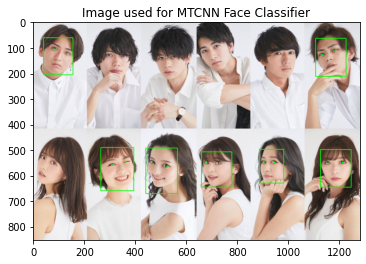

In [55]:
# 导入图片
img = Image.open('img.jpg')
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.title('Image used for MTCNN Face Classifier')

# 导入模型
detector = MTCNN()
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(rgb)

# 检测人脸
print("face number:", len(faces))
for result in faces:
    x, y, w, h = result['box']
    keypoints = result['keypoints']
    x1, y1 = x + w, y + h
    cv2.rectangle(img, (x, y), (x1, y1), (0,255,0), 2)
    cv2.circle(img,(keypoints['left_eye']), 2, (0,255,0), 2)
    cv2.circle(img,(keypoints['right_eye']), 2, (0,255,0), 2)
plt.imshow(img)

# 输出图片
img = Image.fromarray(img)
img.save("pics/learning_MTCNN.jpg")  